In [1]:
!python --version

Python 3.13.7


In [2]:
import json

with open('23092025_graph.json', mode='r', encoding='utf-8') as f:
    data = json.load(f)

list(data.keys())

['Nvidia', 'AMD', 'Intel']

In [3]:
from google import genai
from dotenv import load_dotenv
import os

load_dotenv()

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY", "")
client = genai.Client(api_key=GEMINI_API_KEY)

In [19]:
summary7day_prompt = """
You are an analyst specializing in the semiconductor industry. 

TASK:
Summarize risks and opportunities for **{chipmaker}** over the last 7 days based on extracted knowledge triplets.

INPUT FORMAT:
Each triplet has:
- subject
- relation (verb + optional detail)
- object

Triplets (past 7 days):
{triplets}

INSTRUCTIONS:
1. Carefully analyze the triplets to identify signals of **risks** (e.g., export restrictions, regulatory scrutiny, market struggles, competition, delays).
2. Identify **opportunities** (e.g., new product launches, strong demand, partnerships, positive analyst ratings, technological advances).
3. For each risk or opportunity, **cite the supporting triplet** in this format:
   subject -(verb[/detail])-> object
   Example: China -(scrutinizes)-> Nvidia
4. Organize into two sections:
   - **Risks for {chipmaker}**
   - **Opportunities for {chipmaker}**
5. At the end, write a **short summary outlook** combining both risks and opportunities.

OUTPUT FORMAT:
Risks for {chipmaker}:
- [triplet] → explanation
- ...

Opportunities for {chipmaker}:
- [triplet] → explanation
- ...

Outlook:
<short paragraph>
"""

In [20]:
chipmaker = "Nvidia"
triplets = [t for d in data[chipmaker] for t in d['triplets']]

response = client.models.generate_content(
    model="gemini-2.5-flash", 
    contents=summary7day_prompt.format(
        chipmaker=chipmaker, 
        triplets=triplets
    )
)

print(response.text)

As an analyst specializing in the semiconductor industry, here's a summary of risks and opportunities for Nvidia over the last 7 days:

### Risks for Nvidia:
- **Geopolitical and Market Access Restrictions:**
    - Beijing -(bans/from using Nvidia microchips)-> companies
    - China -(bans/Nvidia AI)-> chips
    - China -(scrutinizes)-> Nvidia
    - Huang -(states/on US China AI dominance)-> patience
    - Nvidia -(exports/to China)-> chips
    → Mounting bans from Beijing and China on the use of Nvidia's microchips and AI chips by local companies, coupled with broader scrutiny, represent a significant geopolitical risk. These restrictions impact market access and export volumes, as highlighted by CEO Jensen Huang's call for "patience" regarding US-China AI dominance.
- **Product-Specific Performance and Competition:**
    - Nvidia -(struggles/to sell RTX6000D)-> GPUs
    - Nvidia -(competes/with APUs)-> AMD
    - Tencent -(breaks)-> Nvidia
    → Nvidia is reportedly struggling with sa

In [21]:
chipmaker = "AMD"
triplets = [t for d in data[chipmaker] for t in d['triplets']]

response = client.models.generate_content(
    model="gemini-2.5-flash", 
    contents=summary7day_prompt.format(
        chipmaker=chipmaker, 
        triplets=triplets
    )
)

print(response.text)

Here's an analysis of AMD's risks and opportunities over the last 7 days:

### Risks for AMD:

-   ROCm -(omits/from supported GPU list)-> Strix Halo → The omission of the new Strix Halo from ROCm's supported GPU list indicates a potential gap in AMD's AI software ecosystem for new hardware, which could limit AI development on these platforms.
-   AMD -(trails)-> Nvidia → AMD continues to trail Nvidia, highlighting a persistent competitive disadvantage, particularly in the high-growth, high-performance GPU and AI accelerator markets where Nvidia dominates.
-   AMD -(trails)-> Broadcom → Trailing Broadcom suggests competitive pressure in other key segments, potentially affecting market share or growth in areas like networking or custom silicon.
-   AMD -(has/Rowhammer DDR5)-> vulnerability → The identification of a Rowhammer DDR5 vulnerability exposes AMD to potential security risks, which could impact product reputation and require significant resources for mitigation.
-   Google -(fin

In [22]:
chipmaker = "Intel"
triplets = [t for d in data[chipmaker] for t in d['triplets']]

response = client.models.generate_content(
    model="gemini-2.5-flash", 
    contents=summary7day_prompt.format(
        chipmaker=chipmaker, 
        triplets=triplets
    )
)

print(response.text)

Here's an analysis of Intel's risks and opportunities over the last 7 days:

### Risks for Intel:

*   **Analyst Downgrade:** Citi has downgraded Intel's stock, signaling a potential decrease in investor confidence.
    *   Intel -(receives/downgrade to Sell from Neutral)-> Citi
*   **Planned Executive Transition:** The announced retirement of Chairman Wang in September 2025 introduces future leadership uncertainty, despite being planned in advance.
    *   Intel -(announces/on September 16, 2025)-> retirement
    *   Wang -(retires/as chair in September 2025)-> Intel

### Opportunities for Intel:

*   **Transformative Partnership and Investment from Nvidia:** Intel has forged a significant partnership with Nvidia, involving a $5 billion investment for a 4% stake, making Nvidia a major shareholder. This collaboration focuses on developing chips, fusing CPUs with GPUs (critical for AI/HPC), and providing strategic support in the competitive foundry landscape against rivals like TSMC. Th

In [4]:
import networkx as nx

G = nx.MultiDiGraph()

for chipmaker in data:
    for d in data[chipmaker]:
        date = d['date']
        for triplet in d['triplets']:
            subject = triplet['subject']
            relation = triplet['relation']
            object_ = triplet['object']

            verb = relation.get("verb")
            detail = relation.get("detail")

            G.add_edge(
                subject,
                object_,
                key=verb,
                verb=verb,
                detail=detail,
                date=date,
                chipmaker=chipmaker
            )

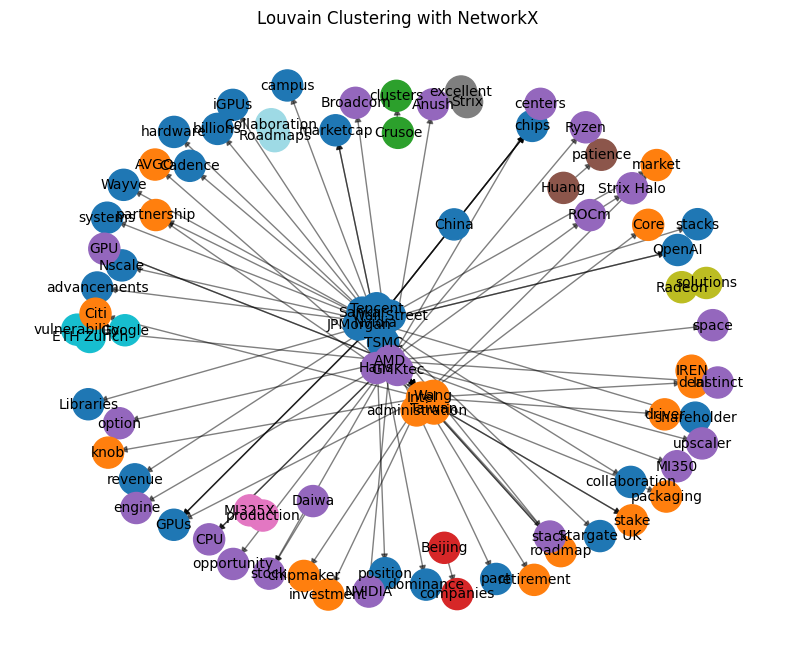

In [9]:
import matplotlib.pyplot as plt

communities = nx.community.louvain_communities(G, seed=123)

community_map = {}
for i, comm in enumerate(communities):
    for node in comm:
        community_map[node] = i

pos = nx.spring_layout(G, seed=42)
node_colors = [community_map[n] for n in G.nodes()]

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.tab20, node_size=500)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

plt.title("Louvain Clustering with NetworkX")
plt.axis("off")
plt.show()

In [17]:
community_prompt = """
You are a financial news and risk analysis assistant. 
You are given a cluster of entities and their relationships extracted from news published in the last 7 days. 
The graph was built using Louvain community detection, where each community represents a group of entities that are closely connected by news relations.

Your task: Summarize the cluster into a clear narrative.

**Subgraph**
{subgraph}

Instructions:
1. Mention the **date and time range** of the news that built this cluster (last 7 days).
2. Highlight the **key entities** in the community (companies, people, or sectors).
3. Describe the **important relationships** between them (e.g., partnerships, lawsuits, investments, supply chain ties).
4. Analyze whether these relations represent **risks, opportunities, or neutral signals** for investors or businesses. 
   - Risk: negative sentiment, conflicts, regulations, financial loss
   - Opportunity: partnerships, growth, positive earnings, market expansion
   - Neutral: informational but no clear risk/opportunity
5. If possible, connect the relationships to **broader market or industry implications**.

Output format:
- Time period
- Key entities
- Main relationships
- Risks
- Opportunities
- Implications

Be concise but insightful, suitable for an investor briefing.
"""

In [20]:
import time, random
from tqdm import tqdm

def serialize_subgraph(subgraph):
    edges = []
    for u, v, data in subgraph.edges(data=True):
        relation = data.get("verb", "related_to")
        detail = data.get("detail", "")
        date = data.get("date", "")
        edges.append(f"{u} --{relation} ({detail}, {date})--> {v}")
    return "\n".join(edges)

def retry_request(func, max_retries=5):
    for attempt in range(max_retries):
        try:
            return func()
        except Exception as e:
            wait = (2 ** attempt) + random.random()
            print(f"Retry {attempt+1}/{max_retries}, waiting {wait:.1f}s due to: {e}")
            time.sleep(wait)
    raise Exception("Max retries reached, service still unavailable")

dict_subgraph = {i: {"subgraph": None, "summary": ""} for i in range(len(communities))}

for i, comm in tqdm(enumerate(communities), total=len(communities)):
    subgraph = G.subgraph(comm)
    dict_subgraph[i]["subgraph"] = subgraph

    subgraph_text = serialize_subgraph(subgraph)

    prompt = community_prompt.format(subgraph=subgraph_text)

    response = retry_request(
        lambda: client.models.generate_content(
            model="gemini-2.5-flash",
            contents=prompt
        )
    )

    dict_subgraph[i]["summary"] = response.text

 73%|███████▎  | 8/11 [02:04<00:48, 16.31s/it]

Retry 1/5, waiting 1.6s due to: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The service is currently unavailable.', 'status': 'UNAVAILABLE'}}
Retry 2/5, waiting 2.9s due to: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The service is currently unavailable.', 'status': 'UNAVAILABLE'}}
Retry 3/5, waiting 4.3s due to: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The service is currently unavailable.', 'status': 'UNAVAILABLE'}}
Retry 4/5, waiting 8.8s due to: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The service is currently unavailable.', 'status': 'UNAVAILABLE'}}
Retry 5/5, waiting 16.0s due to: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The service is currently unavailable.', 'status': 'UNAVAILABLE'}}


 73%|███████▎  | 8/11 [02:46<01:02, 20.81s/it]


Exception: Max retries reached, service still unavailable

In [23]:
dict_subgraph

{0: {'subgraph': <networkx.classes.multidigraph.MultiDiGraph at 0x1c40903d450>,
  'summary': 'Here\'s a summary of the cluster for an investor briefing:\n\n**Time period:** News from September 16-22, 2025.\n\n**Key entities:** The central entity is **Nvidia**, with significant involvement from **OpenAI**, **TSMC**, **Intel**, **JPMorgan**, **Wall Street**, **Samsung**, **Cadence**, **Wayve**, and **Nscale**. Geopolitical factors involving **China** also play a crucial role.\n\n**Main relationships:**\nNvidia is consolidating its dominant position in the AI market, reaffirmed by strong analyst sentiment (JPMorgan "Overweight") and Wall Street\'s interest. It\'s making strategic moves, including a deep partnership and $100 billion investment in OpenAI, providing critical GPUs and systems. Nvidia continues its vital collaboration with TSMC for chip manufacturing and advancements. Notably, Nvidia has formed a pact with Intel and has become its largest shareholder, while also exploring a $5

In [27]:
for i, comm in tqdm(enumerate(communities), total=len(communities)):
    if i >= 9 and i <= 10:
        subgraph = G.subgraph(comm)
        dict_subgraph[i]["subgraph"] = subgraph

        subgraph_text = serialize_subgraph(subgraph)

        prompt = community_prompt.format(subgraph=subgraph_text)

        response = retry_request(
            lambda: client.models.generate_content(
                model="gemini-2.5-flash",
                contents=prompt
            )
        )

        dict_subgraph[i]["summary"] = response.text
    else:
        continue

100%|██████████| 11/11 [00:19<00:00,  1.73s/it]


In [29]:
dict_subgraph

{0: {'subgraph': <networkx.classes.multidigraph.MultiDiGraph at 0x1c40903d450>,
  'summary': 'Here\'s a summary of the cluster for an investor briefing:\n\n**Time period:** News from September 16-22, 2025.\n\n**Key entities:** The central entity is **Nvidia**, with significant involvement from **OpenAI**, **TSMC**, **Intel**, **JPMorgan**, **Wall Street**, **Samsung**, **Cadence**, **Wayve**, and **Nscale**. Geopolitical factors involving **China** also play a crucial role.\n\n**Main relationships:**\nNvidia is consolidating its dominant position in the AI market, reaffirmed by strong analyst sentiment (JPMorgan "Overweight") and Wall Street\'s interest. It\'s making strategic moves, including a deep partnership and $100 billion investment in OpenAI, providing critical GPUs and systems. Nvidia continues its vital collaboration with TSMC for chip manufacturing and advancements. Notably, Nvidia has formed a pact with Intel and has become its largest shareholder, while also exploring a $5

In [30]:
subgraph = dict_subgraph[8]["subgraph"]
subgraph_text = serialize_subgraph(subgraph)

prompt = community_prompt.format(subgraph=subgraph_text)

response = retry_request(
    lambda: client.models.generate_content(
        model="gemini-2.5-flash",
        contents=prompt
    )
)

dict_subgraph[8]["summary"] = response.text

Retry 1/5, waiting 1.6s due to: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The service is currently unavailable.', 'status': 'UNAVAILABLE'}}
Retry 2/5, waiting 2.7s due to: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The service is currently unavailable.', 'status': 'UNAVAILABLE'}}
Retry 3/5, waiting 5.0s due to: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The service is currently unavailable.', 'status': 'UNAVAILABLE'}}
Retry 4/5, waiting 8.8s due to: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The service is currently unavailable.', 'status': 'UNAVAILABLE'}}
Retry 5/5, waiting 16.4s due to: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The service is currently unavailable.', 'status': 'UNAVAILABLE'}}


Exception: Max retries reached, service still unavailable

In [31]:
dict_subgraph[8]["subgraph"].edges(data=True)

OutMultiEdgeDataView([('Radeon', 'solutions', {'verb': 'surpasses', 'detail': 'integrated', 'date': '2025-09-20', 'chipmaker': 'AMD'})])

In [34]:
community_prompt = """
You are a financial news and risk analysis assistant. 
You are given a cluster of entities and their relationships extracted from news published in the last 7 days. 
The graph was built using Louvain community detection, where each community represents a group of entities that are closely connected by news relations.

Your task: Summarize the cluster into a clear narrative.

**Subgraph**
'Radeon', 'solutions', {'verb': 'surpasses', 'detail': 'integrated', 'date': '2025-09-20', 'chipmaker': 'AMD'

Instructions:
1. Mention the **date and time range** of the news that built this cluster (last 7 days).
2. Highlight the **key entities** in the community (companies, people, or sectors).
3. Describe the **important relationships** between them (e.g., partnerships, lawsuits, investments, supply chain ties).
4. Analyze whether these relations represent **risks, opportunities, or neutral signals** for investors or businesses. 
   - Risk: negative sentiment, conflicts, regulations, financial loss
   - Opportunity: partnerships, growth, positive earnings, market expansion
   - Neutral: informational but no clear risk/opportunity
5. If possible, connect the relationships to **broader market or industry implications**.

Output format:
- Time period
- Key entities
- Main relationships
- Risks
- Opportunities
- Implications

Be concise but insightful, suitable for an investor briefing.
"""

response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=community_prompt
    )

dict_subgraph[8]["summary"] = response.text

ServerError: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The service is currently unavailable.', 'status': 'UNAVAILABLE'}}

In [39]:
all_summaries = [d["summary"] for d in dict_subgraph.values() if d["summary"]]

meta_prompt = """
You are a financial news summarizer. 
I will give you summaries of different communities (clusters) built from news about chipmakers in the past 7 days.

Your task:
1. Create a **short overall summary** (5–8 sentences) that captures the big picture.
2. Mention **how the chipmakers interact** across clusters (competition, partnerships, supply chain, etc.).
3. Highlight **key relationships** that represent risk or opportunity for the semiconductor industry.
4. Keep it concise, suitable for an investor briefing.

Cluster Summaries:
{summaries}

Final Overall Summary:
"""

response = client.models.generate_content(
    model="gemini-2.5-flash",
    contents=meta_prompt.format(
        summaries="\n\n".join(all_summaries)
    )
)

overall_summary = response.text
print(overall_summary)

Here's an investor briefing summary of the past week's chipmaker news:

**Overall Summary:**
The semiconductor industry is currently navigating a period of intense strategic maneuvering, with **Nvidia** further cementing its dominant position in the AI market through massive investments, notably a $100 billion partnership with OpenAI. This expansion is underscored by robust analyst confidence and a broad network of alliances, including crucial manufacturing ties with **TSMC** and a significant new shareholder stake in **Intel**. Meanwhile, **Intel** is aggressively pursuing its resurgence, leveraging the Nvidia partnership and attracting interest from the US administration to bolster its strategic roadmaps. **AMD** is actively pushing its new AI accelerators and CPU lines, positioning itself as a formidable challenger in the AI inference and gaming segments, despite fierce competition from Nvidia and a recent security vulnerability disclosure. Underlying these corporate strategies is t